## Data preparation and sanitization

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb
import imblearn

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
#df = pd.read_excel("./UG_HH_NEW_categorical_no200.xls")
df = df.dropna()

df_effort = df[['time_spent_prop', 'count_effort']]
df_effort = (df_effort - df_effort.min()) / (df_effort.max() - df_effort.min())

df['effort'] = df_effort['time_spent_prop'] * df_effort['count_effort']
df = df[['time_spent_risk', 'cells', 'selfish', 'effort',
         'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

df = df[['selfish','Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]


NORMALISE_DATA = True


x = df.values[:, :-1]
y = df.values[:, -1:]

if NORMALISE_DATA:
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    x = (x - x_min) / (x_max - x_min)
    
NB_FEATURES = x.shape[1]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)

## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [2]:
MAX_GAIN = 200

def loss(min_offer, predicted):
    """
    Compute loss for the ultimatum game,
    as the difference between the possible gain and the actual one
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    rejected = min_offer > predicted
    res = predicted - min_offer
    if rejected.sum() != 0:
        res[rejected] = MAX_GAIN - min_offer[rejected]
    bad_predictions = (predicted < 0) | (predicted > MAX_GAIN)
    if bad_predictions.sum() != 0:
        res[bad_predictions] = MAX_GAIN - min_offer[bad_predictions]
    return res

def loss_sum(min_offer, predicted):
    return loss(min_offer, predicted).sum()

def avg_loss(min_offer, predicted):
    """
    Compute avg loss for the ultimatum game
    """
    return np.mean(loss(min_offer, predicted))

def mse(min_offer, predicted):
    """
    Compute mse using the loss as error
    """
    return np.mean(np.square(loss(min_offer, predicted)))

def rejection_ratio(min_offer, predicted):
    """
    Compute ratio of rejected proposals without consideration of values
    """
    accepted = (min_offer <= predicted)
    return 1 - np.mean(accepted)

def avg_win_loss(min_offer, predicted):
    """
    Compute avg_loss of accepted proposals
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    accepted = (min_offer <= predicted)
    if accepted.sum() == 0:
        return 0
    return avg_loss(min_offer[accepted], predicted[accepted])


def gain(min_offer, predicted):
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()    
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def avg_loss_ratio(min_offer, predicted):
    """
    Compute the avg gain ratio in relation to the maximal gain
    """
    return 1 - np.mean(gain(min_offer, predicted) / gain(min_offer, min_offer))


#### Benchmark

In [3]:
benchmark_functions = [avg_loss, mse, rejection_ratio, avg_win_loss, avg_loss_ratio, loss_sum]

from sklearn.model_selection import KFold
import numpy as np

def process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs=None, predict_kwargs=None):
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs
    predict_kwargs = {} if predict_kwargs is None else predict_kwargs
    model.fit(xTrain, yTrain, **fit_kwargs)
    yPredict = model.predict(xTest, **predict_kwargs)
    results = {func.__name__: func(yTest, yPredict) for func in benchmark_functions}
    return results
    
def process_benchmark_cv(model, X, y, cv=5, metrics=None, fit_kwargs=None, predict_kwargs=None, augment_kwargs=None):
    # We make sure original values aren't modified, even by mistake
    X = np.copy(X)
    y = np.copy(y)
    
    kf = KFold(n_splits=cv)
    results = []
    for train_index, test_index in kf.split(X):
        xTrain, yTrain = X[train_index], y[train_index]
        if augment_kwargs:
            xTrain, yTrain = DACombine().fit_predict(xTrain, yTrain, **augment_kwargs)
        xTest, yTest = X[test_index], y[test_index]
        benchmark_result = process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs, predict_kwargs)
        results.append(benchmark_result)
    return pd.DataFrame(results)

** Data augmentation **

In [4]:
class DACombine(object):
    def __init__(self, size=None, nb_features=NB_FEATURES, max_gain=MAX_GAIN):
        self.size = size
        self.nb_features = nb_features
        self.max_gain = max_gain
    
    def fit_predict(self, xTrain, yTrain, size=None, distance=10, upsample=True, include_xy=False, retarget=False, distribution=False, combine=False):
        """
        :param size: (int) size of the new generated dataset
        :param distance: (int) distance between parents or similar items
        :param upsample: (bool) if True, try balance the dataset
        :param include_xy: (bool) if True, include xTrain and yTrain to the data (on top of size items)
        :param retarget: (bool) if True, set all targets to the nearest higher multiple of distance without generating new samples
        :param distribution: (bool) if True, create new sample based on percentiles of features's std
        :param combine: (bool) if True: combine different methods (dist + retarget)
        """
        
        size = size or self.size or len(xTrain) * 4
        if combine:
            if distribution:
                xTrain, yTrain = self.dist_resample(xTrain, yTrain, size)
        else:
            if retarget:
                return self.retarget(xTrain, yTrain, distance)

            if distribution:
                return self.dist_resample(xTrain, yTrain, size)
    
        indices = np.arange(self.nb_features)
        np.random.shuffle(indices)
        targets = yTrain.ravel()
        if upsample:
            targets, counts = np.unique(yTrain, return_counts=True)
            #NOTE: minimize selection of target with only one sample
            probs = (1 - counts/counts.sum())**2
            probs[counts==1] = probs.min()
            probs /= probs.sum()
        else:
            targets = yTrain.ravel()
            probs = None
        xRes = []
        yRes = []
        if include_xy:
            xRes.extend(xTrain)
            yRes.extend(yTrain.ravel())
        for _ in range(size):
            target = np.random.choice(targets, p=probs)
            target_mask = (yTrain.ravel()<target+distance) & (yTrain.ravel()>=(target))
            xTrain_target = xTrain[target_mask]
            i = np.random.randint(xTrain_target.shape[0])
            j = np.random.randint(xTrain_target.shape[0])
            x = np.zeros_like(xTrain_target[0])
            np.random.shuffle(indices)
            split = np.random.randint(self.nb_features)
            mask_i = indices[:split]
            mask_j = indices[split:]
            x[mask_i] = xTrain_target[i, mask_i]
            x[mask_j] = xTrain_target[j, mask_j]
            xRes.append(x)
            yRes.append(target)
        xRes = np.array(xRes)
        yRes = np.array(yRes)
        if combine and retarget:
            return self.retarget(xRes, yRes, distance)
        return np.array(xRes), np.array(yRes)

    def retarget(self, xTrain, yTrain, distance=10):
        yNew = np.zeros(yTrain.shape[0])
        for y in np.arange(self.max_gain, 0, -distance):
            mask = (yTrain <= y) & (yTrain > y-distance)
            yNew[mask] = y + np.random.randint(0, distance, mask.shape)[mask]
        yNew = np.array(yNew)
        yNew[yNew > self.max_gain] = self.max_gain
        return xTrain, yNew
    
    def dist_resample(self, xTrain, yTrain, size=None, std_ratio=0.1):
        size = size or self.size or len(xTrain) * 4
        xTrain_mean = xTrain.mean()
        xTrain_std = xTrain.std()
        xNew = []
        yNew = []
        for _ in range(size):
            idx = np.random.randint(0, xTrain.shape[0])
            x = np.random.normal(xTrain[idx], xTrain_std*std_ratio)
            y = yTrain[idx]
            xNew.append(x)
            yNew.append(y)
        return np.array(xNew), np.array(yNew)
            

    def fit_resample(self, xTrain, yTrain, size=None, distance=5, include_xy=True):
        return self.fit_predict(xTrain, yTrain, size=size, distance=distance, include_xy=include_xy)

In [5]:
#keras
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys


def sigmoid1024_tf(x):
    return (1024**x) / (1024**x + 1)

def sigmoid_tf(x):
    return K.sigmoid(x)

def gain_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.multiply(left_mul, right_mul)


def loss_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x0 = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x0, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.subtract(one*2, tf.math.multiply(left_mul, right_mul))

def _keras_model(loss=None, metrics=None):
    """
    build a simple regression model
    :param loss: (str|callable, default: loss_tf)
    """
    if loss is None:
        loss = loss_tf
    if metrics is None:
        metrics = ["mse"]
    model = Sequential()
    model.add(Dense(8, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def _keras_linear_regression(loss=None, metrics=None):
    if loss is None:
        loss = "mse"
    if metrics is None:
        metrics = ["mse"]
    model = Sequential()
    model.add(Dense(1, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def keras_linear_regression(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_linear_regression(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    
def keras_model(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_model(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)

Using TensorFlow backend.


**Linear regression**

(array([ 4,  5, 28, 13, 26, 38,  1,  3,  0,  1]),
 array([  0. ,  19.5,  39. ,  58.5,  78. ,  97.5, 117. , 136.5, 156. ,
        175.5, 195. ]))

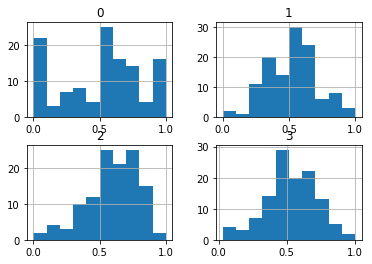

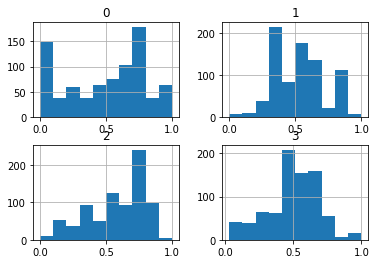

In [6]:
import imblearn
import imblearn.over_sampling
o_s = imblearn.over_sampling.RandomOverSampler()
xTrain_a, yTrain_a = o_s.fit_resample(xTrain, yTrain.ravel(), )
pd.DataFrame(xTrain).hist()
pd.DataFrame(xTrain_a).hist()
np.histogram(yTrain)

In [7]:
from sklearn.linear_model import LinearRegression, BayesianRidge, LogisticRegression, PassiveAggressiveRegressor, \
                                 ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble.bagging import BaggingRegressor, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
benchmark_models = {
    'linear_regression': LinearRegression(),
    'log_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
}
    
augment_params = {
    'base': {},
    'retarget': {'retarget': True, 'distance': 10},
#     'x2': {'size':len(xTrain)*2},
#     'x2-up': {'size':len(xTrain)*2, 'upsample': True},
#     'x2+xy': {'size':len(xTrain)*2, 'include_xy':True},
#     'x4': {'size': len(xTrain)*4},
#     'x4+xy-up': {'size': len(xTrain)*4, 'include_xy':True, 'upsample':True},
    'x16': {'size': len(xTrain)*16},
    'x16-up': {'size': len(xTrain)*16, 'upsample': True},
    'x16_dist': {'size': len(xTrain)*16, 'distribution': True},
    'x16_combine': {'size': len(xTrain)*16, 'retarget': True, 'distribution': True, 'upsample': True},
}

results = {}
for key, model in benchmark_models.items():
    for aug_key, aug_params in augment_params.items():
        results[key+"_" + aug_key] = process_benchmark_cv(model=model, X=x, y=y.ravel(), augment_kwargs=aug_params)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
linear_regression_base,70.742931,0.657645,27.443891,2532.130878,6658.271315,0.586508
linear_regression_retarget,61.636186,0.575220,27.483636,2207.663929,5438.381463,0.485556
linear_regression_x16,73.479820,0.676930,25.417040,2630.085476,7214.976783,0.614444
linear_regression_x16-up,72.822679,0.672122,25.213374,2606.841556,7101.605434,0.608730
linear_regression_x16_combine,62.614871,0.584576,27.496726,2242.433712,5560.801202,0.496825
linear_regression_x16_dist,71.286799,0.662960,27.695264,2551.744702,6715.048389,0.592063
log_regression_base,26.913492,0.219422,23.429033,963.000000,1543.257937,0.072540
log_regression_retarget,32.173016,0.264399,27.518634,1152.000000,1962.720952,0.089048
log_regression_x16,77.700794,0.669020,46.095363,2781.000000,8266.670635,0.480317
log_regression_x16-up,85.774603,0.739705,54.187500,3070.000000,9344.674603,0.558571


** Actual best model:**
- LogisticRegression (penalty='l1')

** Data Augmentation improve following models:**
- Ensemble models

In [8]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
benchmark_models = {
    'bag': BaggingRegressor(),
    'forest': RandomForestRegressor(n_estimators=50),
    #keras_linear_regression(nb_epoch=100, batch_size=60),
}
    
augment_params = {
    'base': {},
    'retarget': {'retarget': True, 'distance': 10},
    'x16': {'size': len(xTrain)*16},
    'x16-up': {'size': len(xTrain)*16, 'upsample': True},
    'x16_dist': {'size': len(xTrain)*16, 'distribution': True},
    'x16_combine': {'size': len(xTrain)*16, 'retarget': True, 'distribution': True},
}

results = {}
for key, model in benchmark_models.items():
    for aug_key, aug_params in augment_params.items():
        results[key+"_" + aug_key] = process_benchmark_cv(model=model, X=x, y=y.ravel(), augment_kwargs=aug_params)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
bag_base,68.586984,0.631243,27.583969,2456.600000,6506.318413,0.552540
bag_retarget,61.737651,0.566591,27.298211,2211.040000,5600.825908,0.468730
bag_x16,70.353962,0.644930,27.016091,2519.555126,6776.191804,0.569365
bag_x16-up,76.458529,0.694387,30.203376,2738.604280,7610.258286,0.619524
bag_x16_combine,62.952286,0.579672,28.709822,2253.820000,5671.096737,0.480159
bag_x16_dist,63.713333,0.588673,27.875210,2282.300000,5852.069206,0.496667
forest_base,67.767016,0.625122,26.599220,2426.540000,6390.267200,0.547143
forest_retarget,60.541616,0.560677,27.328312,2167.652000,5365.878859,0.463333
forest_x16,78.600265,0.708613,33.396578,2815.228460,7935.518168,0.630635
forest_x16-up,75.219094,0.684116,30.026739,2693.877265,7407.228087,0.608413


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2

reg = L1L2(l1=0.01, l2=0.01)
model = Sequential()
model.add(Dense(1, activation='relu', input_dim=x.shape[1]),)# W_regularizer=reg,)
model.compile(optimizer='adam', loss=loss2_tf, metrics=[gain_tf])
xTrain_a, yTrain_a = DACombine().fit_predict(xTrain, yTrain, size=1024)
history = model.fit(xTrain_a, yTrain_a, nb_epoch=500, validation_split=0.25)


/home/franck/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 768 samples, validate on 256 samples
Epoch 1/500
768/768 [==============================] - 2s 2ms/step - loss: 7131.6598 - gain_tf: -0.1574 - val_loss: 6601.5392 - val_gain_tf: -0.2018
Epoch 2/500
768/768 [==============================] - 0s 189us/step - loss: 7121.0742 - gain_tf: -0.1568 - val_loss: 6590.9635 - val_gain_tf: -0.2010
Epoch 3/500
768/768 [==============================] - 0s 216us/step - loss: 7110.3446 - gain_tf: -0.1563 - val_loss: 6580.5612 - val_gain_tf: -0.2002
Epoch 4/500
768/768 [==============================] - 0s 195us/step - loss: 7099.7375 - gain_tf: -0.1557 - val_loss: 6570.0441 - val_gain_tf: -0.1994
Epoch 5/500
768/768 [==============================] - 0s 203us/step - loss: 7089.0842 - gain_tf: -0.1552 - val_loss: 6559.5668 - val_gain_tf: -0.1986
Epoch 6/500
768/768 [==============================] - 0s 204us/step - loss: 7078.4274 - gain_tf: -0.1547 - val_loss: 6549.1409 - val_gain_tf: -0.1978
Epoch 7/500
768/768 [=============================

Epoch 55/500
768/768 [==============================] - 0s 223us/step - loss: 6576.7826 - gain_tf: -0.1291 - val_loss: 6056.6471 - val_gain_tf: -0.1588
Epoch 56/500
768/768 [==============================] - 0s 201us/step - loss: 6567.0208 - gain_tf: -0.1286 - val_loss: 6046.9586 - val_gain_tf: -0.1581
Epoch 57/500
768/768 [==============================] - 0s 193us/step - loss: 6557.2065 - gain_tf: -0.1281 - val_loss: 6037.2266 - val_gain_tf: -0.1573
Epoch 58/500
768/768 [==============================] - 0s 199us/step - loss: 6547.3459 - gain_tf: -0.1276 - val_loss: 6027.5895 - val_gain_tf: -0.1565
Epoch 59/500
768/768 [==============================] - 0s 179us/step - loss: 6537.5538 - gain_tf: -0.1271 - val_loss: 6017.9245 - val_gain_tf: -0.1557
Epoch 60/500
768/768 [==============================] - 0s 174us/step - loss: 6527.7659 - gain_tf: -0.1266 - val_loss: 6008.2700 - val_gain_tf: -0.1549
Epoch 61/500
768/768 [==============================] - 0s 197us/step - loss: 6517.9549 

Epoch 109/500
768/768 [==============================] - 0s 191us/step - loss: 6064.4582 - gain_tf: -0.1023 - val_loss: 5554.5015 - val_gain_tf: -0.1168
Epoch 110/500
768/768 [==============================] - 0s 205us/step - loss: 6055.4082 - gain_tf: -0.1018 - val_loss: 5545.4509 - val_gain_tf: -0.1161
Epoch 111/500
768/768 [==============================] - 0s 186us/step - loss: 6046.2165 - gain_tf: -0.1013 - val_loss: 5536.6000 - val_gain_tf: -0.1153
Epoch 112/500
768/768 [==============================] - 0s 211us/step - loss: 6037.1758 - gain_tf: -0.1008 - val_loss: 5527.6335 - val_gain_tf: -0.1145
Epoch 113/500
768/768 [==============================] - 0s 218us/step - loss: 6028.0905 - gain_tf: -0.1003 - val_loss: 5518.6876 - val_gain_tf: -0.1138
Epoch 114/500
768/768 [==============================] - 0s 220us/step - loss: 6018.8987 - gain_tf: -0.0999 - val_loss: 5510.0329 - val_gain_tf: -0.1130
Epoch 115/500
768/768 [==============================] - 0s 218us/step - loss: 600

768/768 [==============================] - 0s 262us/step - loss: 5597.9539 - gain_tf: -0.0774 - val_loss: 5098.2966 - val_gain_tf: -0.0771
Epoch 163/500
768/768 [==============================] - 0s 200us/step - loss: 5589.4278 - gain_tf: -0.0769 - val_loss: 5090.1351 - val_gain_tf: -0.0764
Epoch 164/500
768/768 [==============================] - 0s 211us/step - loss: 5581.0050 - gain_tf: -0.0765 - val_loss: 5081.8732 - val_gain_tf: -0.0757
Epoch 165/500
768/768 [==============================] - 0s 253us/step - loss: 5572.5715 - gain_tf: -0.0760 - val_loss: 5073.5758 - val_gain_tf: -0.0750
Epoch 166/500
768/768 [==============================] - 0s 219us/step - loss: 5564.1170 - gain_tf: -0.0756 - val_loss: 5065.3150 - val_gain_tf: -0.0742
Epoch 167/500
768/768 [==============================] - 0s 191us/step - loss: 5555.6700 - gain_tf: -0.0751 - val_loss: 5057.1054 - val_gain_tf: -0.0735
Epoch 168/500
768/768 [==============================] - 0s 196us/step - loss: 5547.3142 - gain_

768/768 [==============================] - 0s 216us/step - loss: 5164.3878 - gain_tf: -0.0541 - val_loss: 4675.5929 - val_gain_tf: -0.0396
Epoch 216/500
768/768 [==============================] - 0s 187us/step - loss: 5156.5463 - gain_tf: -0.0537 - val_loss: 4667.8836 - val_gain_tf: -0.0389
Epoch 217/500
768/768 [==============================] - 0s 198us/step - loss: 5148.5845 - gain_tf: -0.0533 - val_loss: 4660.4244 - val_gain_tf: -0.0382
Epoch 218/500
768/768 [==============================] - 0s 188us/step - loss: 5140.8508 - gain_tf: -0.0528 - val_loss: 4652.6796 - val_gain_tf: -0.0375
Epoch 219/500
768/768 [==============================] - 0s 199us/step - loss: 5132.9549 - gain_tf: -0.0524 - val_loss: 4645.0746 - val_gain_tf: -0.0369
Epoch 220/500
768/768 [==============================] - 0s 202us/step - loss: 5125.1587 - gain_tf: -0.0520 - val_loss: 4637.4044 - val_gain_tf: -0.0362
Epoch 221/500
768/768 [==============================] - 0s 203us/step - loss: 5117.2932 - gain_

768/768 [==============================] - 0s 273us/step - loss: 4762.5193 - gain_tf: -0.0325 - val_loss: 4285.0569 - val_gain_tf: -0.0047
Epoch 269/500
768/768 [==============================] - 0s 218us/step - loss: 4755.2385 - gain_tf: -0.0321 - val_loss: 4277.9975 - val_gain_tf: -0.0041
Epoch 270/500
768/768 [==============================] - 0s 195us/step - loss: 4748.0067 - gain_tf: -0.0318 - val_loss: 4270.8622 - val_gain_tf: -0.0034
Epoch 271/500
768/768 [==============================] - 0s 227us/step - loss: 4740.7234 - gain_tf: -0.0314 - val_loss: 4263.8026 - val_gain_tf: -0.0028
Epoch 272/500
768/768 [==============================] - 0s 229us/step - loss: 4733.4324 - gain_tf: -0.0310 - val_loss: 4256.8489 - val_gain_tf: -0.0022
Epoch 273/500
768/768 [==============================] - 0s 194us/step - loss: 4726.2406 - gain_tf: -0.0306 - val_loss: 4249.7959 - val_gain_tf: -0.0015
Epoch 274/500
768/768 [==============================] - 0s 253us/step - loss: 4719.0064 - gain_

768/768 [==============================] - 0s 230us/step - loss: 4391.7069 - gain_tf: -0.0126 - val_loss: 3925.9138 - val_gain_tf: 0.0272
Epoch 322/500
768/768 [==============================] - 0s 215us/step - loss: 4385.0298 - gain_tf: -0.0123 - val_loss: 3919.3667 - val_gain_tf: 0.0278
Epoch 323/500
768/768 [==============================] - 0s 229us/step - loss: 4378.2772 - gain_tf: -0.0119 - val_loss: 3912.9763 - val_gain_tf: 0.0284
Epoch 324/500
768/768 [==============================] - 0s 211us/step - loss: 4371.6531 - gain_tf: -0.0115 - val_loss: 3906.4764 - val_gain_tf: 0.0290
Epoch 325/500
768/768 [==============================] - 0s 216us/step - loss: 4364.9246 - gain_tf: -0.0111 - val_loss: 3900.1349 - val_gain_tf: 0.0295
Epoch 326/500
768/768 [==============================] - 0s 248us/step - loss: 4358.3454 - gain_tf: -0.0108 - val_loss: 3893.6252 - val_gain_tf: 0.0301
Epoch 327/500
768/768 [==============================] - 0s 205us/step - loss: 4351.6269 - gain_tf: -0

Epoch 375/500
768/768 [==============================] - 0s 209us/step - loss: 4045.4687 - gain_tf: 0.0062 - val_loss: 3592.0339 - val_gain_tf: 0.0566
Epoch 376/500
768/768 [==============================] - 0s 251us/step - loss: 4039.3414 - gain_tf: 0.0066 - val_loss: 3586.1966 - val_gain_tf: 0.0571
Epoch 377/500
768/768 [==============================] - 0s 219us/step - loss: 4033.2293 - gain_tf: 0.0069 - val_loss: 3580.3891 - val_gain_tf: 0.0576
Epoch 378/500
768/768 [==============================] - 0s 201us/step - loss: 4027.1890 - gain_tf: 0.0073 - val_loss: 3574.4634 - val_gain_tf: 0.0581
Epoch 379/500
768/768 [==============================] - 0s 205us/step - loss: 4021.0850 - gain_tf: 0.0076 - val_loss: 3568.5989 - val_gain_tf: 0.0586
Epoch 380/500
768/768 [==============================] - 0s 204us/step - loss: 4015.0215 - gain_tf: 0.0079 - val_loss: 3562.7271 - val_gain_tf: 0.0591
Epoch 381/500
768/768 [==============================] - 0s 212us/step - loss: 4008.9537 - gai

768/768 [==============================] - 0s 207us/step - loss: 3730.9007 - gain_tf: 0.0238 - val_loss: 3290.2070 - val_gain_tf: 0.0826
Epoch 430/500
768/768 [==============================] - 0s 223us/step - loss: 3725.3520 - gain_tf: 0.0241 - val_loss: 3284.9292 - val_gain_tf: 0.0830
Epoch 431/500
768/768 [==============================] - 0s 210us/step - loss: 3719.8700 - gain_tf: 0.0244 - val_loss: 3279.5844 - val_gain_tf: 0.0835
Epoch 432/500
768/768 [==============================] - 0s 219us/step - loss: 3714.3089 - gain_tf: 0.0247 - val_loss: 3274.3719 - val_gain_tf: 0.0839
Epoch 433/500
768/768 [==============================] - 0s 191us/step - loss: 3708.8247 - gain_tf: 0.0251 - val_loss: 3269.1465 - val_gain_tf: 0.0844
Epoch 434/500
768/768 [==============================] - 0s 201us/step - loss: 3703.3824 - gain_tf: 0.0254 - val_loss: 3263.8296 - val_gain_tf: 0.0848
Epoch 435/500
768/768 [==============================] - 0s 204us/step - loss: 3697.8657 - gain_tf: 0.0257 -

768/768 [==============================] - 0s 202us/step - loss: 3447.6038 - gain_tf: 0.0403 - val_loss: 3020.0201 - val_gain_tf: 0.1053
Epoch 484/500
768/768 [==============================] - 0s 215us/step - loss: 3442.6628 - gain_tf: 0.0406 - val_loss: 3015.2310 - val_gain_tf: 0.1057
Epoch 485/500
768/768 [==============================] - 0s 209us/step - loss: 3437.6633 - gain_tf: 0.0409 - val_loss: 3010.5814 - val_gain_tf: 0.1061
Epoch 486/500
768/768 [==============================] - 0s 175us/step - loss: 3432.7406 - gain_tf: 0.0412 - val_loss: 3005.9216 - val_gain_tf: 0.1065
Epoch 487/500
768/768 [==============================] - 0s 210us/step - loss: 3427.8450 - gain_tf: 0.0415 - val_loss: 3001.2154 - val_gain_tf: 0.1069
Epoch 488/500
768/768 [==============================] - 0s 194us/step - loss: 3422.8951 - gain_tf: 0.0418 - val_loss: 2996.6100 - val_gain_tf: 0.1073
Epoch 489/500
768/768 [==============================] - 0s 233us/step - loss: 3418.0019 - gain_tf: 0.0421 -

In [10]:
yPred = model.predict(xTest)


In [11]:
_, yy = DACombine().retarget(xTrain, yTrain.ravel(), 20)
#yy - yTrain.ravel()
yy


array([ 66., 119.,  58., 115., 165.,  74., 118.,  83.,  68.,  84., 164.,
       200.,  26., 110., 113.,  67.,  85., 109.,  88.,  89.,  75.,  61.,
        50.,  63.,  40., 111.,  41., 100.,  94.,  96.,  41.,  68.,  80.,
       103.,  31.,  95.,  83.,  66., 111.,  88.,  79., 102.,  74., 116.,
        77., 106.,  87., 103., 115.,  87.,  93., 108., 117., 113.,  67.,
        21.,  65., 143., 117.,  62., 126.,  81., 136., 113., 106.,  94.,
        67., 100.,  60.,  60., 119.,   0., 108.,  78., 111.,  60., 116.,
       116.,  86.,  81., 103.,  96., 104., 107.,  79.,  77., 115.,  90.,
        61.,  65., 111.,  89.,  63., 107., 109., 114.,  21.,  98., 100.,
       103.,  78., 174., 106., 112., 111., 105., 116., 116., 116.,  88.,
       110.,  75.,  83.,  52.,  54.,  80., 101.,  79., 124.])